# Lab 3 - Convolutional Neural Networks (CNNs)

In this lab we will:
- Understand the basics of Convolutional Neural Networks (CNNs)
- Implement a simple CNN using PyTorch
- Train and evaluate the CNN on the MNIST and CIFAR-10 datasets
- Create a Trainer class to handle the training and evaluation process with Weights & Biases (wandb) integration

In [ ]:
# We will use the following libraries in our examples:

import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import wandb

!wandb login 2f4725bbec8770a63ad5cb3e1ff15f1e53b756f6  # Log in to your W&B account

torch.manual_seed(42)  # For reproducibility

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
Using device: cpu


For visualization, we will use the `visualise` function:

In [ ]:
def visualise(dataset, grid = (3, 3)):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=(8, 8))
    for i in range(grid[0]):
        for j in range(grid[1]):
            idx = numpy.random.randint(len(dataset))
            img, label = dataset[idx]
            axes[i, j].imshow(img, cmap='gray' if img.mode == 'L' else None)
            axes[i, j].set_title(f'Label: {label}')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

Load the MNIST dataset similarly to the previous lab, print basic information about the dataset, and visualize some samples using the `visualise` function:

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.83MB/s]


MNIST dataset size: 60000
MNIST image shape: (28, 28)


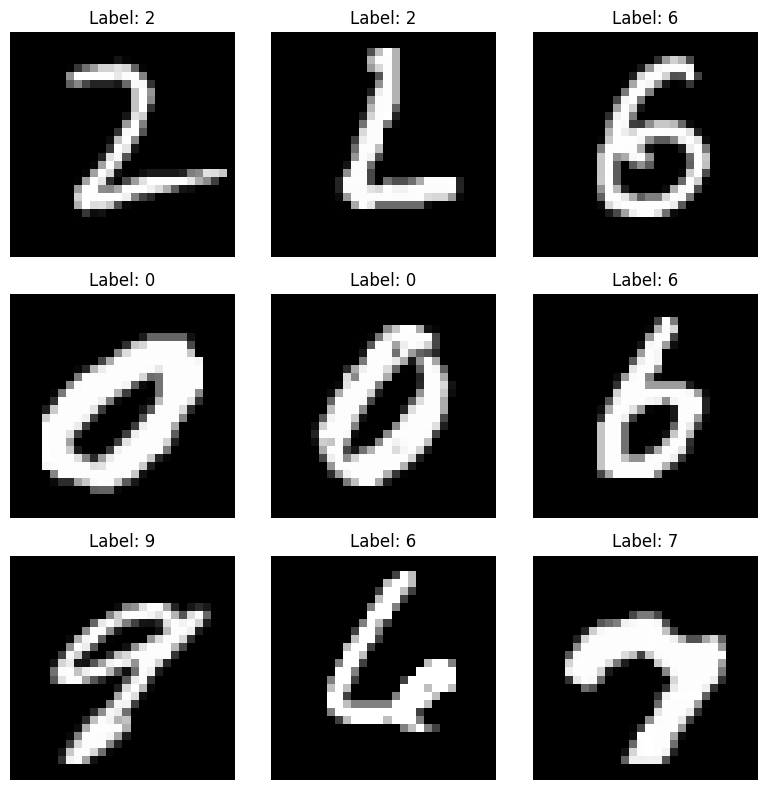

In [ ]:
mnist_train = MNIST('./data', download=True)

print(f'MNIST dataset size: {len(mnist_train)}')
print(f'MNIST image shape: {mnist_train[0][0].size}')

visualise(mnist_train)

Doing the same for CIFAR-10:

100%|██████████| 170M/170M [00:05<00:00, 28.8MB/s]


CIFAR-10 dataset size: 50000
CIFAR-10 image shape: (32, 32)


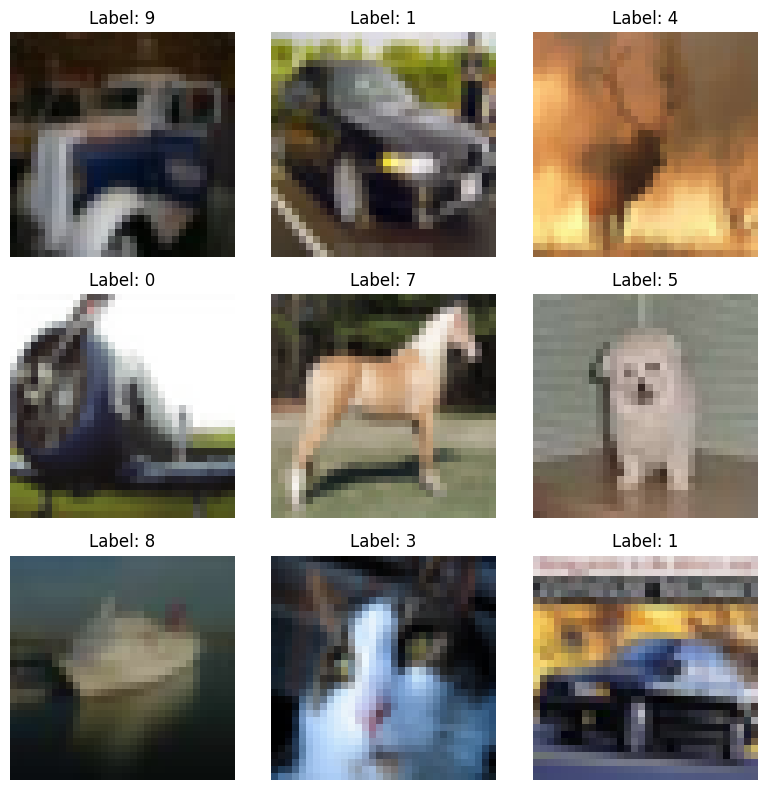

In [ ]:
cifar10_train = CIFAR10('./data', download=True, train=True)

print(f'CIFAR-10 dataset size: {len(cifar10_train)}')
print(f'CIFAR-10 image shape: {cifar10_train[0][0].size}')

visualise(cifar10_train)

As you can see, the CIFAR-10 dataset is more complex than MNIST, with colored images and higher resolution (MNIST images are 28x28 pixels, while CIFAR-10 images are 32x32 pixels). This makes CIFAR-10 a more challenging dataset for image classification tasks.

Now, let's prepare the training, validation, and test data loaders for both datasets. In this exercise, we will use also the validation set (which we remember is 20% of the training set) to monitor the training process and to save the best model based on validation accuracy.

Both datasets are primally in PIL format, so we need to convert them to tensors and normalize them. For MNIST, as in previous lab, we need it to normalize only to rage [0, 1], what is done by `transforms.ToTensor()`. For CIFAR-10, we will normalize the images to have a mean of 0.5 and a standard deviation of 0.5 for each channel (RGB). It results in pixel values ranging from -1 to 1. This normalization helps in speeding up the convergence during training. To achieve this, we will use the `transforms.Normalize` function with the specified mean and standard deviation values ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).

To do this, we will use the `transforms.Compose` function to chain multiple transformations together.

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

mnist = MNIST('./data', download=True, transform=transform, train=True)
mnist_test = MNIST('./data', download=True, transform=transform, train=False)
mnist_train, mnist_val = random_split(mnist, [0.8, 0.2])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10 = CIFAR10('./data', download=True, transform=transform, train=True)
cifar10_test = CIFAR10('./data', download=True, transform=transform, train=False)
cifar10_train, cifar10_val = random_split(cifar10, [0.8, 0.2])

print(f'MNIST train size: {len(mnist_train)}, val size: {len(mnist_val)}, test size: {len(mnist_test)}')
print(f'CIFAR-10 train size: {len(cifar10_train)}, val size: {len(cifar10_val)}, test size: {len(cifar10_test)}')

MNIST train size: 48000, val size: 12000, test size: 10000
CIFAR-10 train size: 40000, val size: 10000, test size: 10000


For each dataset, we will create three data loaders: one for training, one for validation, and one for testing. We will use a batch size of 64 for all data loaders. The training data loader will shuffle the data to ensure that the model sees the data in a different order during each epoch, while the validation and test data loaders will not shuffle the data.

In [ ]:
train_loader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader_mnist = DataLoader(mnist_test, batch_size=64, shuffle=False)

train_loader_cifar10 = DataLoader(cifar10_train, batch_size=64, shuffle=True)
val_loader_cifar10 = DataLoader(cifar10_val, batch_size=64, shuffle=False)
test_loader_cifar10 = DataLoader(cifar10_test, batch_size=64, shuffle=False)

## CNN Model

In the previous lab, we implemented a simple Multi-Layer Perceptron (MLP) for image classification, which worked well for the MNIST dataset. However, MNIST dataset consists of simple grayscale images of handwritten digits, which are relatively easy to classify. When we move to more complex datasets like CIFAR-10, which contains colored images of various objects, the MLP may not perform as well due to its limited ability to capture spatial hierarchies and local patterns in the data. Additionally, for larger images, the number of parameters in an MLP can become very large, leading to overfitting and increased computational requirements.

> For example, first layer of MLP for MNIST has 784 (28 * 28) inputs and 128 outputs, so it has 784 * 128 = 100352 parameters. For CIFAR-10, if we flatten the 32x32x3 images, we get 3072 inputs. If we keep the same number of outputs (128), the first layer would have 3072 * 128 = 393216 parameters, which is significantly larger. If we consider images of size 224x224x3 (like in ImageNet), the first layer would have 150528 inputs, leading to 150528*128 = 19267584 parameters, which is impractical.

To address these problems, people came up with Convolutional Layers, which are designed to process data with a grid-like topology, such as images. Convolutional layers use a set of learnable filters (or kernels) that slide over the input image to capture local patterns and spatial hierarchies. Simple visualization of convolution operation is shown below (source: [link](https://www.cs.cmu.edu/~bhiksha/courses/deeplearning/Spring.2019/archive-f19/www-bak11-22-2019/document/note/hwnotes/hw2/hw2.html)):

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab3_cnn/figures/convolution_layer.gif width="400">

Parameters of convolutional layer are:
- in_channels: Number of channels in the input image or feature map (e.g., 3 for RGB images, 1 for grayscale images).
- out_channels: Number of filters (or kernels) in the convolutional layer. Each filter will produce a separate output channel (feature map).
- kernel_size: Size of the filters (kernels). It can be a single integer (for square kernels) or a tuple (height, width).
- stride: Step size with which the filter moves across the input image. A stride of 1 means the filter moves one pixel at a time, while a stride of 2 means it moves two pixels at a time.
- padding: Number of pixels added to the border of the input image. Padding helps to control the spatial dimensions of the output feature map.

What is important, parameters kernel_size, stride and padding affect the spatial dimensions of the output feature map. The output height and width can be calculated using the following formulas:

```
Output Height = (Input Height - Kernel Height + 2 * Padding) / Stride + 1
Output Width = (Input Width - Kernel Width + 2 * Padding) / Stride + 1
```

> For example, if we have an input image of size 32x32, a kernel size of 3x3, a stride of 1, and a padding of 1, the output feature map will have the same spatial dimensions as the input image (32x32). However, if we use a stride of 2, the output feature map will be reduced to 16x16.

Additionally, Convolutional Neural Networks often include other types of layers, with the most common being Pooling Layers. Pooling layers are used to reduce the spatial dimensions of the feature maps, which helps to decrease the number of parameters and computations in the network, as well as to control overfitting. The most common type of pooling is Max Pooling, which takes the maximum value from a defined region (e.g., 2x2) of the feature map, as shown below (source: [link](https://nico-curti.github.io/NumPyNet/NumPyNet/layers/maxpool_layer.html)):

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab3_cnn/figures/maxpool.gif width="400">

In our implementation, we will use the following architecture for our CNN:
- Convolutional Layer with input channels = 1 (for MNIST) or 3 (for CIFAR-10), output channels = 32, kernel size = 3, stride = 1, padding = 1
- ReLU Activation Function
- Max Pooling Layer with kernel size = 2 and stride = 2 (this will reduce the spatial dimensions by half)
- Convolutional Layer with input channels = 32, output channels = 64, kernel size = 3, stride = 1, padding = 1
- ReLU Activation Function
- Max Pooling Layer with kernel size = 2 and stride = 2 (this will again reduce the spatial dimensions by half)
- Flatten Layer to convert the 2D feature maps to a 1D feature vector
- Fully Connected Layer with input features = 64 * 7 * 7 (for MNIST) or 64 * 8 * 8 (for CIFAR-10), output features = 128
- ReLU Activation Function
- Fully Connected Layer with input features = 128, output features = 10 (number of classes)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,
                 input_channels,
                 num_classes):

        super(ConvNet, self).__init__()
        self.input_channels = input_channels

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7 if self.input_channels  == 1 else 64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7 if self.input_channels == 1 else 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_mnist = ConvNet(input_channels=1, num_classes=10).to(device)
model_cifar10 = ConvNet(input_channels=3, num_classes=10).to(device)

print(model_mnist)
print(model_cifar10)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Now, let's prepare the Trainer class to handle the training and evaluation process with Weights & Biases (wandb) integration.

In the Trainer class, we will implement the following methods:
- `__init__`: Initialize the Trainer class with:
    - model: The neural network model to be trained
    - train_loader: DataLoader for the training dataset
    - val_loader: DataLoader for the validation dataset
    - test_loader: DataLoader for the test dataset
    - criterion: Loss function (CrossEntropyLoss for multi-class classification)
    - optimizer: Optimization algorithm (Adam optimizer)
    - num_epochs: Number of epochs to train the model
    - group: Group name for wandb logging ('mnist' or 'cifar10' for easy identification)
    - name: Your name or any identifier for the run
- `training_epoch`: Single epoch of training, which includes:
    - Setting the model to training mode
    - Iterating over the training data loader
    - Forward pass, loss computation, backward pass, and optimizer step
    - Calculating running loss and accuracy for the epoch
    - Returning the average loss and accuracy for the epoch
- `evaluate`: Evaluate the model on a given data loader (validation or test), which includes:
    - Setting the model to evaluation mode and disabling gradient computation
    - Iterating over the data loader
    - Forward pass and loss computation
    - Calculating running loss and accuracy
    - Returning the average loss and accuracy
- `train`: Main training loop, which includes:
    - Initializing wandb logging
    - Iterating over the number of epochs
    - Calling `training_epoch` for training
    - Calling `evaluate` on the validation set
    - Logging training and validation metrics to wandb
    - Saving the best model based on validation accuracy (using `torch.save` and `model.state_dict()`)
    - After training, evaluating the best model (using `torch.load` and `self.model.load_state_dict()`) on the test set and logging the test metrics to wandb
    - Finishing wandb logging

In [ ]:
class Trainer():
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 test_loader,
                 criterion,
                 optimizer,
                 num_epochs=25,
                 group="mnist", # or "cifar10"
                 name="Kamil Jeziorek"):

        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.name = name
        self.group = group

    def training_epoch(self, data_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss = running_loss / len(data_loader)
        accuracy = 100 * correct / total
        return loss, accuracy

    def evaluate(self, data_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        loss = running_loss / len(data_loader)
        accuracy = 100 * correct / total
        return loss, accuracy

    def train(self):
        wandb.init(project="lab3-cnn",
                   entity="deep-neural-network-course",
                   name=self.name,
                   group=self.group)
        wandb.watch(self.model, log="all")
        best_val_accuracy = 0.0

        for epoch in range(self.num_epochs):
            train_loss, train_accuracy = self.training_epoch(self.train_loader)
            val_loss, val_accuracy = self.evaluate(self.val_loader)

            wandb.log({
                "Epoch": epoch + 1,
                "Train Loss": train_loss,
                "Train Accuracy": train_accuracy,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_accuracy
            })

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(self.model.state_dict(), f'best_model_{self.group}.pth')
                print('Best model saved!')

        self.model.load_state_dict(torch.load(f'best_model_{self.group}.pth'))

        test_loss, test_accuracy = self.evaluate(self.test_loader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        wandb.log({
            "Test Loss": test_loss,
            "Test Accuracy": test_accuracy
        })
        wandb.finish()

Now, lets run the training and evaluation process for both datasets using the Trainer class.

In [ ]:
# Training and evaluating the model on MNIST
trainer_mnist = Trainer(model=model_mnist,
                        train_loader=train_loader_mnist,
                        val_loader=val_loader_mnist,
                        test_loader=test_loader_mnist,
                        criterion=nn.CrossEntropyLoss(),
                        optimizer=optim.Adam(model_mnist.parameters(), lr=0.001),
                        num_epochs=25,
                        group="mnist",
                        name="Roman Nowak")

# Training and evaluating the model on MNIST
trainer_mnist.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: romannowak9 (romannowak9-agh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/25], Train Loss: 0.2063, Train Accuracy: 93.69%, Validation Loss: 0.0799, Validation Accuracy: 97.64%
Best model saved!
Epoch [2/25], Train Loss: 0.0558, Train Accuracy: 98.34%, Validation Loss: 0.0619, Validation Accuracy: 98.13%
Best model saved!
Epoch [3/25], Train Loss: 0.0384, Train Accuracy: 98.80%, Validation Loss: 0.0478, Validation Accuracy: 98.53%
Best model saved!
Epoch [4/25], Train Loss: 0.0280, Train Accuracy: 99.11%, Validation Loss: 0.0432, Validation Accuracy: 98.75%
Best model saved!
Epoch [5/25], Train Loss: 0.0219, Train Accuracy: 99.29%, Validation Loss: 0.0411, Validation Accuracy: 98.72%
Epoch [6/25], Train Loss: 0.0176, Train Accuracy: 99.45%, Validation Loss: 0.0364, Validation Accuracy: 98.89%
Best model saved!
Epoch [7/25], Train Loss: 0.0130, Train Accuracy: 99.59%, Validation Loss: 0.0374, Validation Accuracy: 98.84%
Epoch [8/25], Train Loss: 0.0104, Train Accuracy: 99.69%, Validation Loss: 0.0431, Validation Accuracy: 98.80%
Epoch [9/25], Train Lo

Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇███████████████████
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▆▇▇▇▇▇▆▆▇█▇▆▇▆▇█▇██▇▇
Validation Loss,█▅▃▂▂▁▁▂▂▂▃▄▂▄▃▄▃▇▅▄▅▃▄▅▆
Epoch,25
Test Accuracy,99.19
Test Loss,0.04232
Train Accuracy,99.93542


In [ ]:
# Training and evaluating the model on CIFAR-10

trainer_cifar10 = Trainer(model=model_cifar10,
                        train_loader=train_loader_cifar10,
                        val_loader=val_loader_cifar10,
                        test_loader=test_loader_cifar10,
                        criterion=nn.CrossEntropyLoss(),
                        optimizer=optim.Adam(model_cifar10.parameters(), lr=0.001),
                        num_epochs=25,
                        group="cifar10",
                        name="Roman Nowak")
# Training and evaluating the model on CIFAR-10
trainer_cifar10.train()

This lab is partially based on the following resources:

- https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html